# Baseline model

- Value of Product: Improve health of general public

- Prediction: PM2.5 (particle concentration per cubic meter)

- Hypothesis: Temperature and windspeed are the most important features.

- Model: Linear regression with features ['temp', 'wind_spd', 'wind_dir']

- Metric: RMSE (as recommended by Zindi) = 43.04

In [28]:
# Data manipulation
import pandas as pd
import numpy as np
import missingno as msno

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
rs = 42

In [30]:
df_main = pd.read_csv('data/train_daily_mean.csv')

In [31]:
df_main.isna().sum()

ID                 0
day                0
temp            1314
precip          1405
rel_humidity    1277
wind_dir        1520
wind_spd        1520
atmos_press     1276
dtype: int64

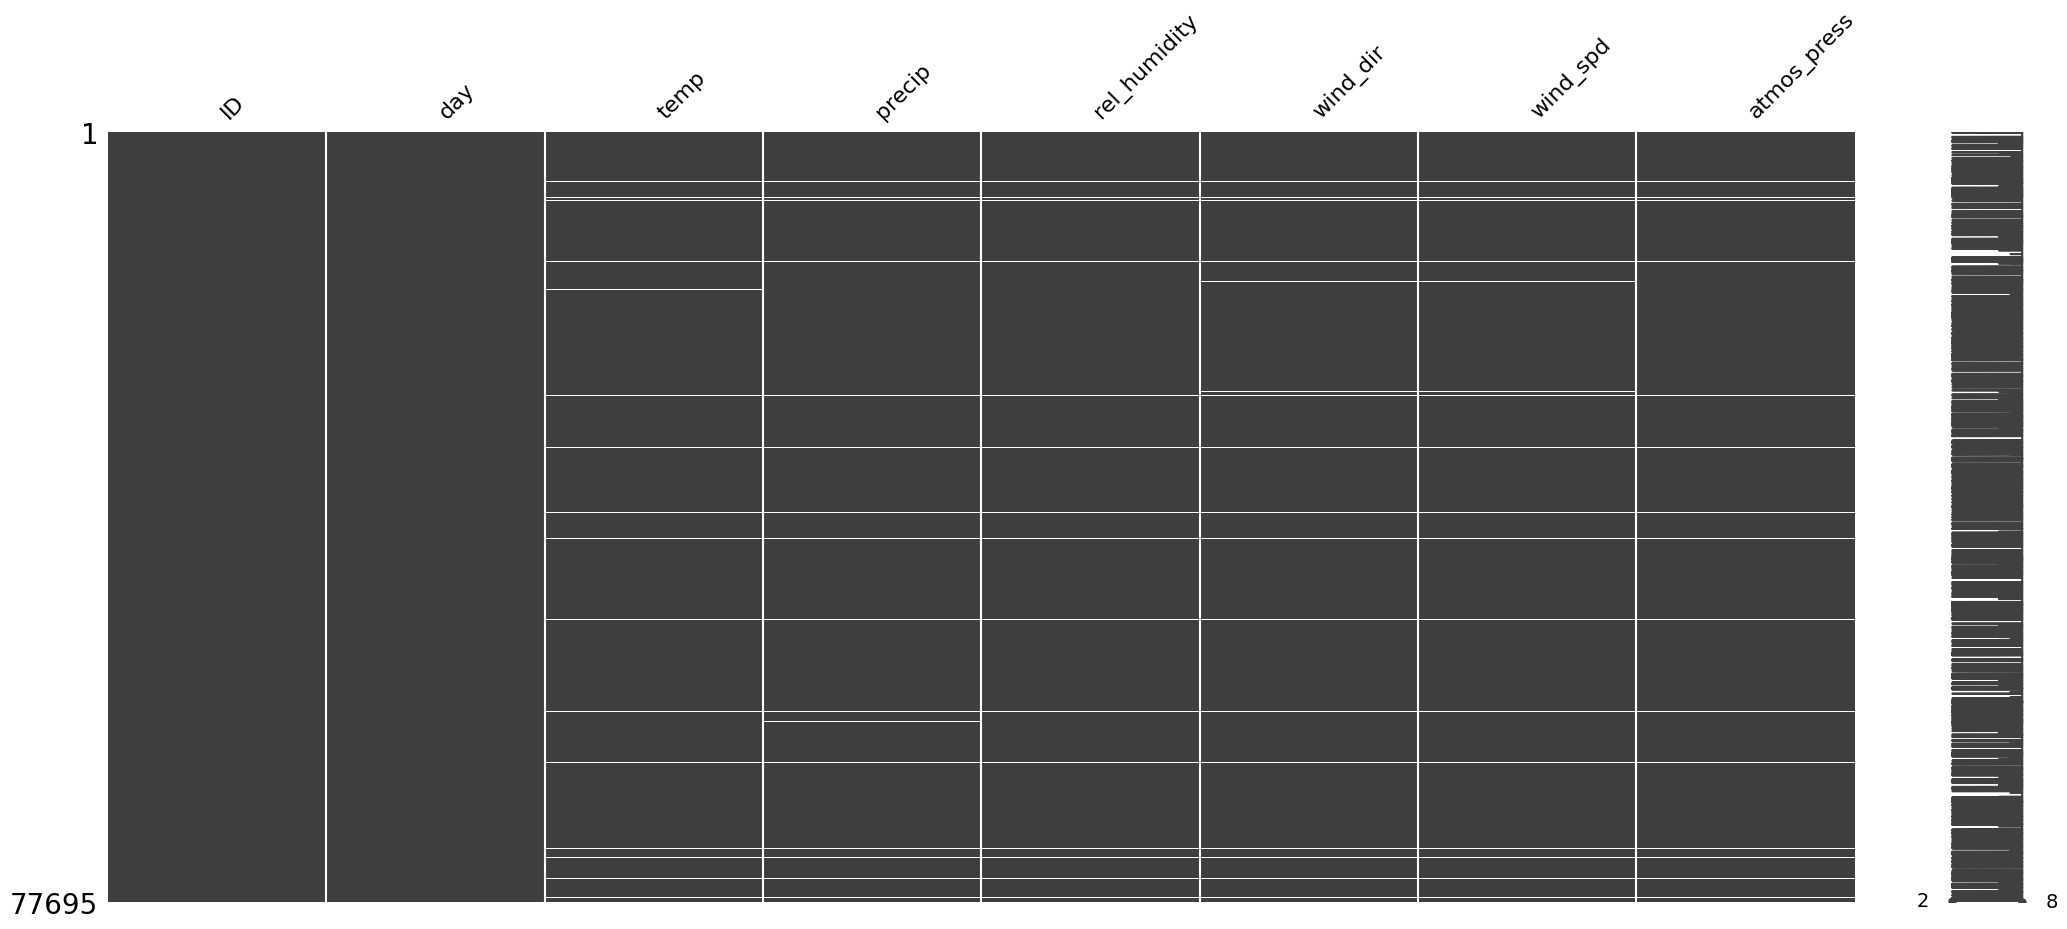

In [32]:
msno.matrix(df_main);

In [33]:
df_clean = df_main.dropna(axis=0)

In [34]:
rows_dropped_percent = np.round(100 - (df_clean.shape[0] / df_main.shape[0]) * 100, 2)
print(f"Dropped {rows_dropped_percent}% of rows.")

Dropped 2.17% of rows.


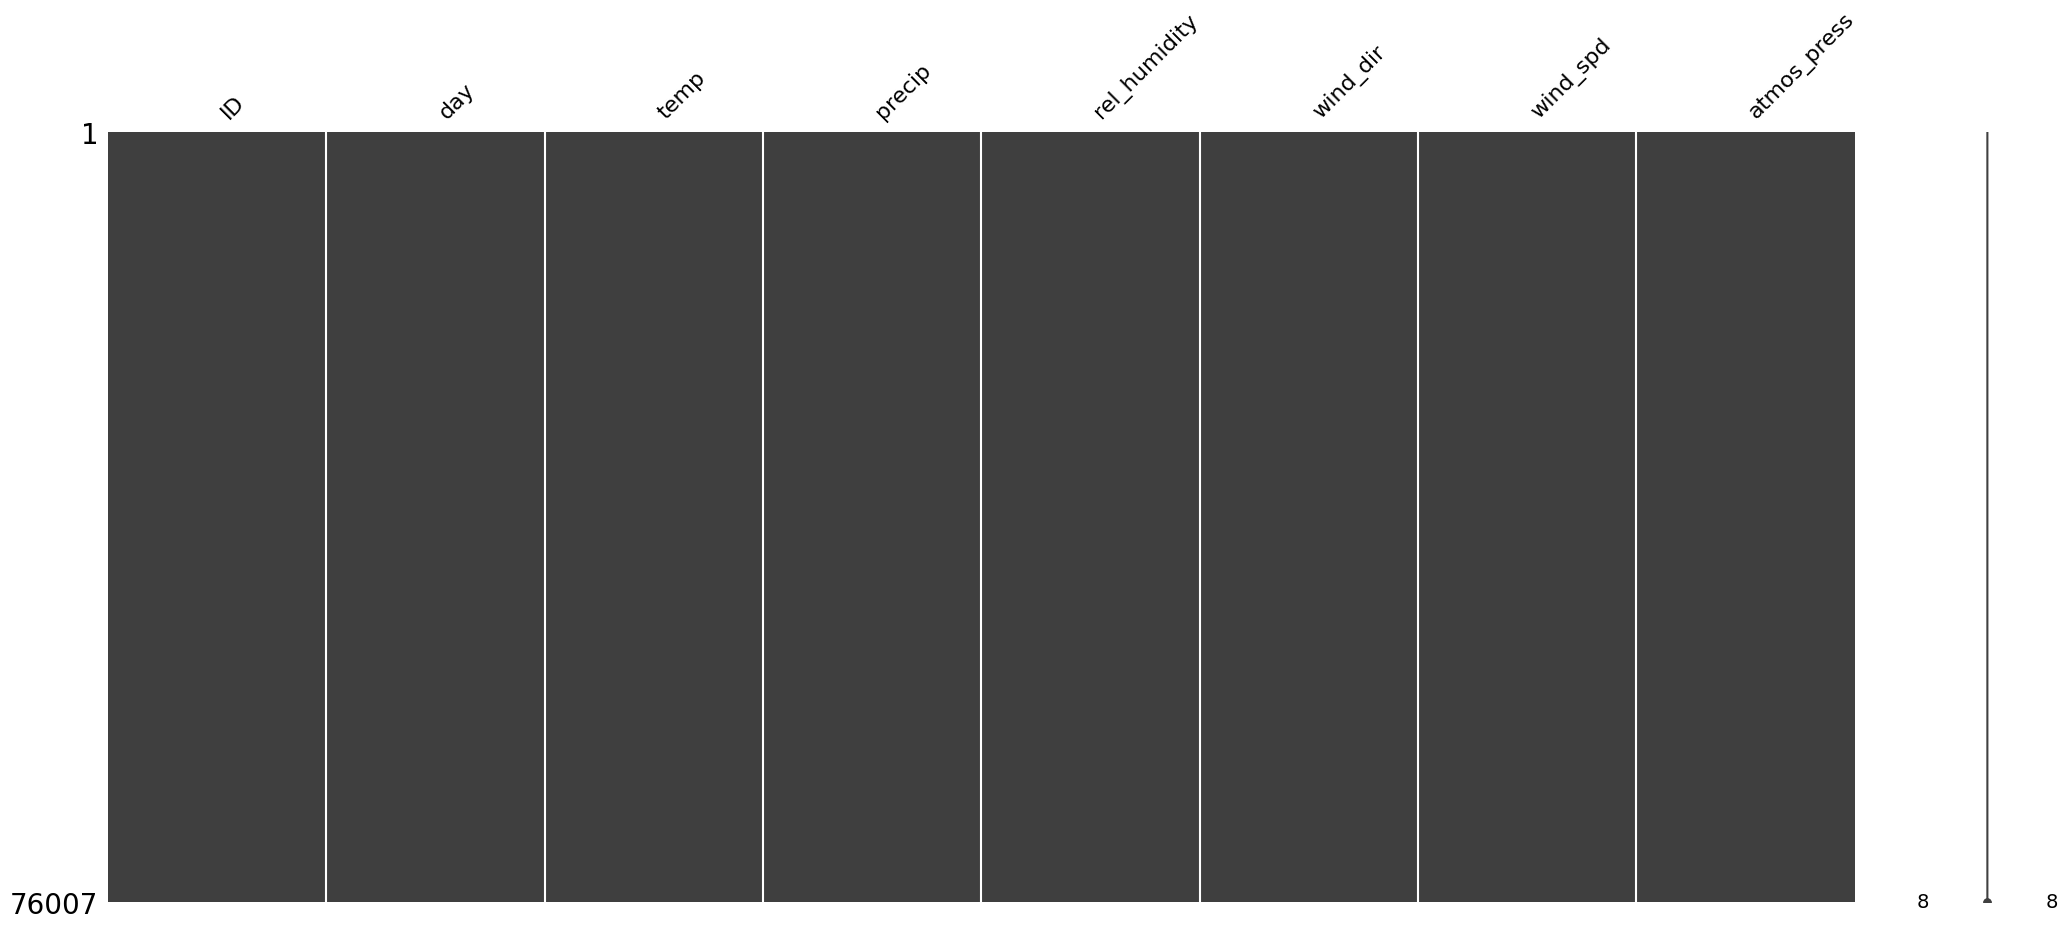

In [35]:
msno.matrix(df_clean);

In [36]:
# check for incomplete 5-day observation sets
labels = df_clean.groupby('ID')['day'].count() == 5
labels = labels.reset_index()

type(labels)

pandas.core.frame.DataFrame

In [37]:
df_clean.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76007 entries, 4 to 77694
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            76007 non-null  object 
 1   day           76007 non-null  float64
 2   temp          76007 non-null  float64
 3   precip        76007 non-null  float64
 4   rel_humidity  76007 non-null  float64
 5   wind_dir      76007 non-null  float64
 6   wind_spd      76007 non-null  float64
 7   atmos_press   76007 non-null  float64
dtypes: float64(7), object(1)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      15539 non-null  object
 1   day     15539 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 136.7+ KB


In [38]:
# remove non-complete observation sets
df_clean = df_clean.merge(labels, on='ID')
df_clean = df_clean[df_clean['day_y'] == True]
df_clean

rows_dropped_percent = 100 - (df_clean.shape[0] / df_main.shape[0]) * 100
print(f"Dropped {rows_dropped_percent}% of rows.")

Dropped 5.695347190938932% of rows.


In [39]:
# readding target
targets = pd.read_csv('data/Train.csv', usecols=['ID', 'target'])
targets

,ID,target
0,ID_train_0,45.126304
1,ID_train_1,79.131702
2,ID_train_10,32.661304
3,ID_train_100,53.850238
4,ID_train_1000,177.418750
...,...,...
15534,ID_train_9995,44.850286
15535,ID_train_9996,24.330455
15536,ID_train_9997,38.972128
15537,ID_train_9998,41.720952


In [40]:
df_clean = df_clean.merge(targets, on='ID', how='inner')

## Baseline model

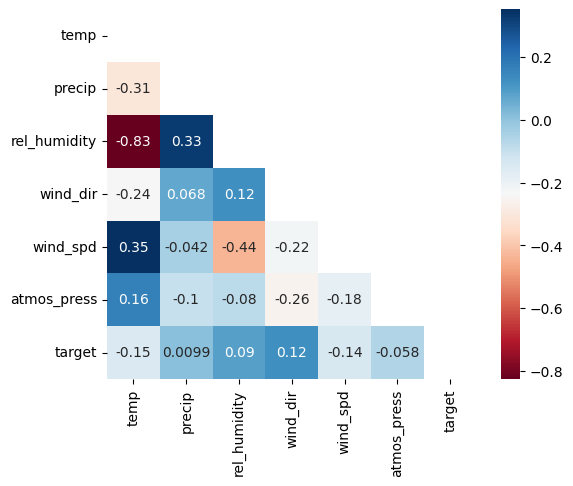

In [41]:
# check correlation matrix for contributions
corrs = df_clean.iloc[:, 2:].drop('day_y', axis=1).corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, mask=mask, cmap=plt.colormaps.get('RdBu'), annot=True, square=True);

In [42]:
# All features: ['ID', 'day_x', 'temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd','atmos_press', 'day_y', 'target']
features = ['temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd','atmos_press', 'target']
df_baseline = df_clean.groupby('ID')[features].mean()
df_baseline = df_baseline.reset_index().drop('ID', axis=1)
df_baseline.head(1)

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,24.679736,0.00701,0.757967,177.089494,0.900148,90.430503,79.131702


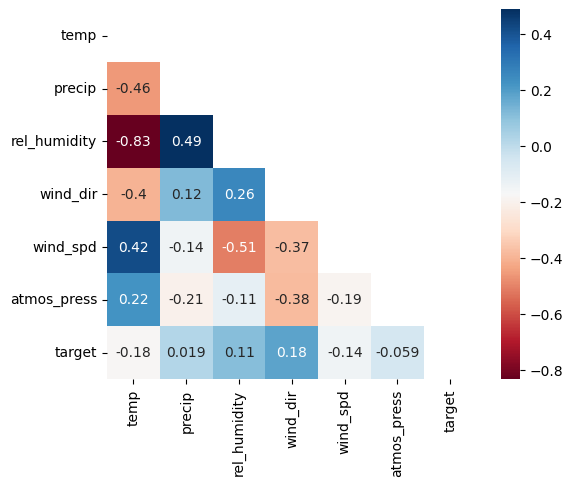

In [43]:
# check correlation matrix for contributions after averaging 5 day intervals
corrs = df_baseline.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, mask=mask, cmap=plt.colormaps.get('RdBu'), annot=True, square=True);

In [44]:
# reducing features
df_baseline = df_baseline[['temp', 'wind_dir', 'wind_spd', 'rel_humidity', 'target']]

In [45]:
y = df_baseline.pop('target')
X = df_baseline

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
y_pred = lr.predict(X_test)

In [49]:
print(f"RMSE for model {lr}: {np.round(mean_squared_error(y_test, y_pred, squared=False), 2)}")

RMSE for model LinearRegression(): 43.04


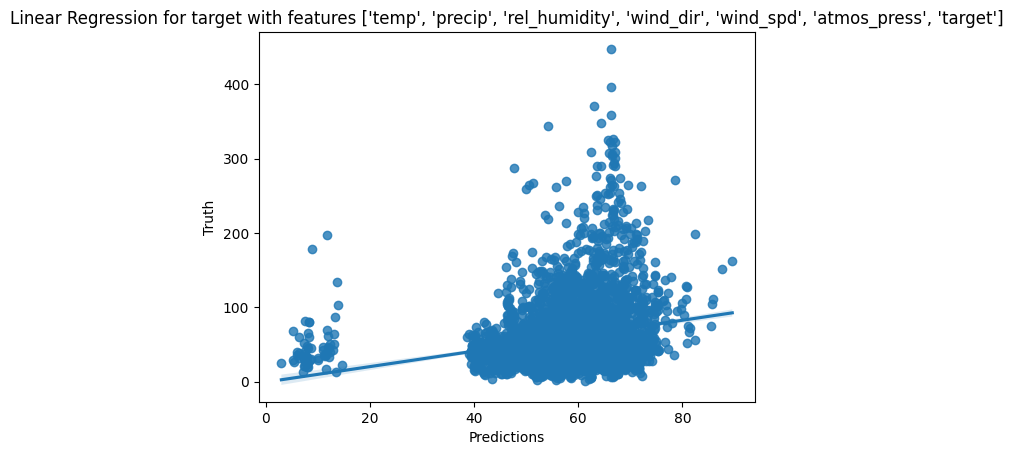

In [50]:
fig = sns.regplot(x=y_pred, y=y_test)
fig.set_title(f"Linear Regression for target with features {features}")
fig.set_ylabel('Truth')
fig.set_xlabel('Predictions');